Pair strategy is a type of **relative value** strategies or **statistical arbitrage**
which rely on the **mean-reversion** of prices to the asset's fair value.
They assume that prices only temporarily move away from fair value due to behavioral effects
like overreaction or herding, or liquidity effects such as temporary market impact or long-term supply/demand friction.



*   Find the price **correlated** HK stocks in **same sector** for Pair strategy
*   Buy the stock when it is relatively **under-priced** to the correlated stock and sell the corresponding **over-priced** stock
*   As they're price correlated (statistically), assume they will go back to the similar price ratio later (mean reversion)
*   Hence (hopefully), the under-priced stock (bought) will goes up later while the over-priced (sold) one will drop


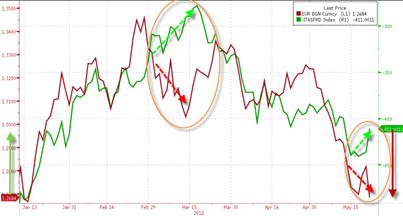

In [1]:
#@title Choose the language to display the stock names and run this block to import libraries and helper functions

language = 'English' #@param ["English", "Chinese"]

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web

# Download the font to display Chinese
!wget https://github.com/kenwkliu/ideas/raw/master/colab/data/simhei.ttf
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
CNFont = FontProperties(fname='/content/simhei.ttf')
%matplotlib inline

# Yahoo Finance
import yfinance as yf

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

import ipywidgets as widgets
from IPython.display import display, clear_output


# 20220202: Temp workaround for the pandas upgrade
# !pip install --upgrade openpyxl

### Helper functions
# Display the stock info in Chinese or not
def useChinese(use=True):
  # return STOCK_INFO_FILE, RESEARCH_AJD_CLOSE_FILE, TEST_AJD_CLOSE_FILE
  if use:
    return 'hkStocksQuotesChi.xlsx', 'researchHKStocksAdjClosePxChi.csv', 'testHKStocksAdjClosePxChi.csv'

  else:
    return 'hkStocksQuotes.xlsx', 'researchHKStocksAdjClosePx.csv', 'testHKStocksAdjClosePx.csv'


STOCK_INFO_FILE, RESEARCH_AJD_CLOSE_FILE, TEST_AJD_CLOSE_FILE = useChinese(False)

CHART_SIZE_X, CHART_SIZE_Y = 12, 8
SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y = 8, 6


# Plot stock pair chart
def plotPair(df, stockA, stockB, sizeX, sizeY):
  ax1 = df[stockA].plot(label=stockA, legend=True, figsize = (sizeX, sizeY))
  ax1.set_ylim(df[stockA].min(), df[stockA].max())

  ax2 = df[stockB].plot(secondary_y=True, label=stockB, legend=True, figsize = (sizeX, sizeY))
  ax2.set_ylim(df[stockB].min(), df[stockB].max())

  ax1.legend(prop=CNFont, loc=2)
  ax2.legend(prop=CNFont, loc=1)

  plt.show()


# Filter the correlated stock pairs with the THRESHOLD
def getCorrelatedPairs(stocksCorr, THRESHOLD=0.95):
  # filter the pairs with correlation values above the THRESHOLD
  highCorr = stocksCorr[((stocksCorr >= THRESHOLD) & (stocksCorr < 1))]
  highCorr = highCorr.unstack().sort_values(ascending=False).drop_duplicates()
  highCorr.dropna(inplace=True)
  highCorrDf = highCorr.to_frame().reset_index()
  highCorrDf.rename(columns = {'level_0':'stockA', 'level_1':'stockB', 0:'corr'}, inplace=True)

  # looks up the sectors for the stocksA and stockB
  cols = ['stockA', 'stockB', 'corr', 'sector_A', 'sector_B']
  pairsDf = highCorrDf.merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockA', right_on='shortName').merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockB', right_on='shortName', suffixes=('_A', '_B'))[cols]
  pairsDf['sameSector'] = (pairsDf['sector_A'] == pairsDf['sector_B'])

  return pairsDf


### back test related functions

# based on the reserch data to determind the trading params (Enter/Exit Points)
def researchTradingParams(researchData, stockA, stockB, threshold=0.05):
  tradingParams = {}
  cols = [stockA, stockB]
  research_df = researchData[cols].copy()
  research_df.dropna(inplace = True)

  # Calculate avgPxRatio for Exit (convergence)
  research_df['ratio'] = research_df[stockA] / research_df[stockB]
  avgPxRatio = research_df['ratio'].mean()
  tradingParams['avgPxRatio'] = avgPxRatio

  # Calculate shortA_longB_ratio for Entry (Divergence)
  shortA_longB_ratio = avgPxRatio * (1 + threshold)
  tradingParams['shortA_longB_ratio'] = shortA_longB_ratio

  # Calculate longA_shortB_ratio from Entry (Divergence)
  longA_shortB_ratio = avgPxRatio * (1 - threshold)
  tradingParams['longA_shortB_ratio'] = longA_shortB_ratio

  return tradingParams


# Determind the signal and dollarValue in the test data
# Currently one dollarValue will be used for all the trade
# Future improvement can adjust the dollarValue per entry signals
# signal == -1: Long stockA Short stockB
# signal == 1: Short stockA Long stockB
# signal == 0: flat position
def backTest(testData, tradingParams, stockA, stockB, dollarValue=10000, stopLoss=0):
  cols = [stockA, stockB]
  backTest_df = testData[cols].copy()
  backTest_df.dropna(inplace = True)

  # Get the tradingParams
  avgPxRatio = tradingParams['avgPxRatio']
  shortA_longB_ratio = tradingParams['shortA_longB_ratio']
  longA_shortB_ratio = tradingParams['longA_shortB_ratio']

  # Calc the stopLoss value
  if stopLoss > 0:
    stopLossUp = shortA_longB_ratio * (1 + stopLoss)
    stopLossDown = longA_shortB_ratio * (1 - stopLoss)

  # Calculate the Price ratio in backTest_df
  backTest_df['pxRatio'] = backTest_df[stockA] / backTest_df[stockB]
  backTest_df['dollarValue'] = dollarValue #one dollarValue will be used for all the trade

  # initialize the signal to 0
  backTest_df['signal'] = 0
  signal = 0

  # Determine the signal in each row of the backTest_df
  for index, row in backTest_df.iterrows():
    pxRatio = row['pxRatio']

    # If hit the stopLoss, will exit the trade entirely
    if stopLoss > 0 and (pxRatio > stopLossUp or pxRatio < stopLossDown):
      break

    # mark signal = 1 if pxRatio > shortA_longB_ratio (Diverge outside the upper band)
    if pxRatio > shortA_longB_ratio:
      signal = 1

    # mark signal = -1 if pxRatio < longA_shortB_ratio (Diverge outside the lower band)
    elif pxRatio < longA_shortB_ratio:
      signal = -1

    else:
      # continue to mark signal = 1 if previous signal == 1 and pxRatio > avgPxRatio (Trade entered but not converge back yet)
      if signal == 1 and pxRatio > avgPxRatio:
        signal = 1

      # continue to mark signal = -1 if previous signal == -1 and pxRatio < avgPxRatio (Trade entered but not converge back yet)
      elif signal == -1 and pxRatio < avgPxRatio:
        signal = -1

      else:
        signal = 0

    backTest_df.loc[index, 'signal'] = signal

  return backTest_df


# determine pSignal and nSignal for up/down markers in plot
# pSignal and nSignal is for displaying the up/down markers in plotting chart only, they're not required for backtest calculation
def addSignalMarker(backTest_df):
  backTest_df['pSignal'] = np.where(backTest_df['signal'] == 1, backTest_df['pxRatio'], np.nan)
  backTest_df['nSignal'] = np.where(backTest_df['signal'] == -1, backTest_df['pxRatio'], np.nan)

  return backTest_df


# Combine the research and backtest for a Portfolio of Pairs
def researchAndBackTestPortfolio(pairsDf, researchData, testData, threshold=0.05, dollarValue=10000, stopLoss=0, printOutput=True):
  pairsPortfolioBackTest = []

  for index, row in pairsDf.iterrows():
    stockA, stockB = row['stockA'], row['stockB']
    if printOutput: print(stockA, 'vs', stockB)
    tradingParams = researchTradingParams(researchData, stockA, stockB, threshold)
    pairsPortfolioBackTest.append(backTest(testData, tradingParams, stockA, stockB, dollarValue, stopLoss)[[stockA, stockB, 'signal', 'dollarValue']])

  return pairsPortfolioBackTest


### Calculate PnL related functions
TRADING_DAYS_IN_YEARS = 256

# Calculate the PnL of the Pair portfolio
def calcPortfolio(pairsBackTest, interestRate=0.03, commRate=0.005):
	portfolio = []
	portfolioPnl = 0

	for backtestDf in pairsBackTest:
		stats, pnlDf = calcPnl(backtestDf, interestRate, commRate)
		pnl = stats['tradingPnL'] - stats['shortInterest'] - stats['transCost']

		stockA = backtestDf.columns[0]
		stockB = backtestDf.columns[1]
		print(f"{stockA} vs {stockB} ---> ${pnl:.2f}")

		portfolio.append([stockA, stockB, stats['tradingPnL'], stats['shortInterest'], stats['transCost'], pnl])
		portfolioPnl += pnl

	print("=================================================================")
	print(f"PortfolioPnl: ${portfolioPnl:.2f}")
	portfolioDf = pd.DataFrame(portfolio, columns=['stockA', 'stocksB', 'tradingPnL', 'shortInterest', 'transCost', 'Pnl'])
	return portfolioPnl, portfolioDf


# Calculate the PnL of one Pair
def calcPnl(backTest_df, interestRate=0.03, commRate=0.005):
	dailyInterestRate = interestRate / TRADING_DAYS_IN_YEARS
	pnl_df = backTest_df.copy()

	pnl_df[['longPos', 'shortPos', 'longValue', 'shortValue', 'longPnl', 'shortPnl', 'shortInterest', 'transCost', 'pnl', 'totalPnl']] = 0
	signal, longPos, shortPos, longValue, shortValue, longPnl, shortPnl, shortInterest, transCost, pnl, accumPnl, totalPnl = 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0

	for index, row in pnl_df.iterrows():
		currentSignal = row['signal']
		transCost = 0

		# When trading signal is changed
		if currentSignal != signal:
			if currentSignal == 0:
				transCost = (curentLongValue + curentShortValue) * commRate
				longValue = 0
				shortValue = 0

			else:
				longValue = row['dollarValue']
				shortValue = row['dollarValue']
				transCost = (longValue + shortValue) * commRate

			longPos = getLongPos(currentSignal, longValue, row)
			shortPos = getShortPos(currentSignal, shortValue, row)

			longPnl = 0
			shortPnl = 0

			pnl = 0
			accumPnl = totalPnl

		#Store current row value
		pnl_df.loc[index, 'transCost'] = transCost

		pnl_df.loc[index, 'longPos'] = longPos
		pnl_df.loc[index, 'shortPos'] = shortPos

		curentLongValue = getLongValue(currentSignal, longPos, row)
		pnl_df.loc[index, 'longValue'] = curentLongValue

		curentShortValue = getShortValue(currentSignal, shortPos, row)
		pnl_df.loc[index, 'shortValue'] = curentShortValue

		currentLongPnl = curentLongValue - longValue
		pnl_df.loc[index, 'longPnl'] = currentLongPnl

		currentShortPnl = shortValue - curentShortValue
		pnl_df.loc[index, 'shortPnl'] = currentShortPnl

		if curentShortValue > 0:
			curentShortInterest = row['dollarValue'] * dailyInterestRate
		else:
			curentShortInterest = 0

		pnl_df.loc[index, 'shortInterest'] = curentShortInterest

		currentPnl = currentLongPnl + currentShortPnl
		pnl_df.loc[index, 'pnl'] = currentPnl

		totalPnl = accumPnl + currentPnl
		pnl_df.loc[index, 'totalPnl'] = totalPnl

		signal = currentSignal

	tradingPnL = pnl_df['totalPnl'].iloc[-1]

	stats = {}
	stats['tradingPnL'] = tradingPnL
	stats['shortInterest'] = pnl_df['shortInterest'].sum()
	stats['transCost'] = pnl_df['transCost'].sum()

	return stats, pnl_df


def getLongPos(signal, longValue, row):
	if longValue == 0 or signal == 0 : return 0
	if signal == -1: return longValue / row[0]
	if signal == 1: return longValue / row[1]


def getShortPos(signal, shortValue, row):
	if shortValue == 0 or signal == 0 : return 0
	if signal == -1: return shortValue / row[1]
	if signal == 1: return shortValue / row[0]


def getLongValue(signal, longPos, row):
	if longPos == 0 or signal == 0 : return 0
	if signal == -1: return longPos * row[0]
	if signal == 1: return longPos * row[1]


def getShortValue(signal, shortPos, row):
	if shortPos == 0 or signal == 0 : return 0
	if signal == -1: return shortPos * row[1]
	if signal == 1: return shortPos * row[0]


--2026-01-13 01:39:02--  https://github.com/kenwkliu/ideas/raw/master/colab/data/simhei.ttf
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/simhei.ttf [following]
--2026-01-13 01:39:03--  https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/simhei.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9751960 (9.3M) [application/octet-stream]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   9.30M  --.-KB/s    in 0.08s   

2026-01-13 01:39:04 (113 MB/s) - ‘simhei.ttf’ saved [9751960/9751960]



# 1. Source the stocks info

*   Source the **year 2020** stock data from **Yahoo finance**
*   Source the stock industries/sectors from **HKET**: http://www1.hket.com/finance/chart/industry-index.do


In [2]:
#@title Get the pre-downloaded (2020-Jul) all HK stocks information from yahoo and merged with stock sectors
# Pandas support reading Excel directly
if language == 'Chinese':
	STOCK_INFO_FILE, RESEARCH_AJD_CLOSE_FILE, TEST_AJD_CLOSE_FILE = useChinese(True)
else:
	 STOCK_INFO_FILE, RESEARCH_AJD_CLOSE_FILE, TEST_AJD_CLOSE_FILE = useChinese(False)

stocksInfo = pd.read_excel('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/' + STOCK_INFO_FILE)
stocksInfo

code        shortName                industry  \
0      4333.HK          CISCO-T  Information Technology   
1      4335.HK          INTEL-T  Information Technology   
2      4338.HK      MICROSOFT-T  Information Technology   
3      9988.HK          BABA-SW  Information Technology   
4      0700.HK          TENCENT  Information Technology   
...        ...              ...                     ...   
2730  83186.HK  CICCKRANECNET-R                     ETF   
2731  83188.HK     CAM CSI300-R                     ETF   
2732  83197.HK  CAM MSCI AINC-R                     ETF   
2733  83199.HK  CSOP CTPBBOND-R                     ETF   
2734  87001.HK    HUI XIAN REIT                    Fund   

                            sector language region quoteType quoteSourceName  \
0     Telecommunications Equipment    en-US     US    EQUITY   Delayed Quote   
1                   Semi-conductor    en-US     US    EQUITY   Delayed Quote   
2          Technology and Software    en-US     US    EQUITY   Delayed Quote   
3          E-commerce and Internet    en-US     US    EQUITY   Delayed Quote   
4          Online and Mobile Games    en-US     US    EQUITY   Delayed Quote   
...                            ...      ...    ...       ...             ...   
2730                Equities-China    en-US     US    EQUITY   Delayed Quote   
2731                Equities-China    en-US     US    EQUITY   Delayed Quote   
2732                Equities-China    en-US     US    EQUITY   Delayed Quote   
2733                         Bonds    en-US     US    EQUITY   Delayed Quote   
2734                          REIT    en-US     US    EQUITY   Delayed Quote   

      triggerable currency  ... tradeable   price earningsTimestamp  \
0           False      HKD  ...     False  150.00               NaN   
1           False      HKD  ...     False  300.00               NaN   
2           False      HKD  ...     False  500.00               NaN   
3           False      HKD  ...     False  248.20               NaN   
4           False      HKD  ...     False  548.00      1.597216e+09   
...           ...      ...  ...       ...     ...               ...   
2730        False      CNY  ...     False   80.18               NaN   
2731        False      CNY  ...     False   48.42               NaN   
2732        False      CNY  ...     False   11.42               NaN   
2733        False      CNY  ...     False  102.70               NaN   
2734        False      CNY  ...     False    1.90      1.552662e+09   

     earningsTimestampStart earningsTimestampEnd trailingPE  \
0                       NaN                  NaN        NaN   
1                       NaN                  NaN        NaN   
2                       NaN                  NaN        NaN   
3                       NaN                  NaN        NaN   
4              1.597216e+09         1.597216e+09  49.754498   
...                     ...                  ...        ...   
2730                    NaN                  NaN        NaN   
2731                    NaN                  NaN        NaN   
2732                    NaN                  NaN        NaN   
2733                    NaN                  NaN        NaN   
2734           1.552662e+09         1.552662e+09        NaN   

      epsTrailingTwelveMonths epsForward  forwardPE  dividendDate  
0                         NaN        NaN        NaN           NaN  
1                         NaN        NaN        NaN           NaN  
2                         NaN        NaN        NaN           NaN  
3                         NaN        NaN        NaN           NaN  
4                    11.01408      10.94  50.091408           NaN  
...                       ...        ...        ...           ...  
2730                      NaN        NaN        NaN           NaN  
2731                      NaN        NaN        NaN           NaN  
2732                      NaN        NaN        NaN           NaN  
2733                      NaN        NaN        Na

In [3]:
#@title List the unique industries names
industryNames = stocksInfo['industry'].unique()
print('Count:', len(industryNames))
print(industryNames)


Count: 23
['Information Technology' 'Financial' 'Telecommunications' 'Energy'
 'Food and Beverage' 'Real Estate Construction' 'Meida and Communications'
 'Medicine' 'Betting' 'Transportation, logistics and infrastructure'
 'Consumer Goods Manufacturing' 'Conglomerate' 'Retail' 'Electricity'
 'Automobile production and distribution' 'Industry'
 'Environmental protection' 'Consumer Service' 'Industrial Products'
 'Raw Materials' 'Index leveraged products' 'Fund' 'ETF']


In [4]:
#@title List the unique sector names
sectorNames = stocksInfo['sector'].unique()
print('Count:', len(sectorNames))
print(sectorNames)

Count: 123
['Telecommunications Equipment' 'Semi-conductor' 'Technology and Software'
 'E-commerce and Internet' 'Online and Mobile Games'
 'State-owned China banks' 'China Telecom' 'International Insurance'
 'Bank' 'China Insurance' 'Other financial services' 'Oil and gas'
 'Alcoholic Beverages' 'Real Estate Development'
 'Media Entertainment Culture Publishing' 'Pharmaceutical'
 'China Properties' 'Macau Gaming' 'Public Transport' 'Toys'
 'Conglomerate' 'Biotechnology' 'Sporting Goods'
 'Gas and Public Utilities' 'Catering' 'Electric utility' 'Supermarket'
 'small and medium China banks' 'Automobile' 'Mobile phone related'
 'Machinery' 'Dairy related' 'Textile and Clothing' 'Healthcare'
 'Property Management and Agent' 'Auto sales' 'Infrastructure'
 'Agricultural and Fishery products'
 'Food and beverage Production and Wholesale' 'Local Telecom'
 'Real Estate Investment' 'Water utilities' 'Jewelry Watches' 'Snack Food'
 'Cement' 'Clothing Accessories' 'Photovoltaic Solar' 'Packaged f

# 2. **Stock Selection**:
Choose the set of the stocks that we are interested to trade in our portfolios


*   Not small names nor penny stocks
*   Has enough **liquidity** for trading purpose



In [5]:
#@title Look at the subset of useful columns and sort by largest marketCap
SELECTED_COLUMNS = ['code', 'quoteType', 'shortName', 'industry', 'sector', 'marketCap', 'regularMarketPreviousClose', 'averageDailyVolume10Day']

stocksInfo[SELECTED_COLUMNS].sort_values(by=['marketCap'], ascending=False)

code quoteType        shortName                industry  \
2      4338.HK    EQUITY      MICROSOFT-T  Information Technology   
3      9988.HK    EQUITY          BABA-SW  Information Technology   
4      0700.HK    EQUITY          TENCENT  Information Technology   
14     1398.HK    EQUITY             ICBC               Financial   
11     2318.HK    EQUITY          PING AN               Financial   
...        ...       ...              ...                     ...   
2729  83170.HK    EQUITY   ISHARESKS200-R                     ETF   
2730  83186.HK    EQUITY  CICCKRANECNET-R                     ETF   
2731  83188.HK    EQUITY     CAM CSI300-R                     ETF   
2732  83197.HK    EQUITY  CAM MSCI AINC-R                     ETF   
2733  83199.HK    EQUITY  CSOP CTPBBOND-R                     ETF   

                            sector     marketCap  regularMarketPreviousClose  \
2          Technology and Software  1.197435e+13                      500.00   
3          E-commerce and Internet  5.370378e+12                      244.80   
4          Online and Mobile Games  5.236233e+12                      535.00   
14         State-owned China banks  2.752837e+12                        4.65   
11                 China Insurance  1.820020e+12                       82.65   
...                            ...           ...                         ...   
2729  Equities-Asia (except Japan)           NaN                       88.02   
2730                Equities-China           NaN                       79.14   
2731                Equities-China           NaN                       47.30   
2732                Equities-China           NaN                       11.32   
2733                         Bonds           NaN                      102.90   

      averageDailyVolume10Day  
2                         0.0  
3                  25690873.0  
4                  20457768.0  
14                161543498.0  
11                 31290439.0  
...                       ...  
2729                      NaN  
2730                      NaN  
2731                 661361.0  
2732                  10550.0  
2733                    892.0  

[2735 rows x 8 columns]

In [6]:
#@title Input a minimum turnover value
MIN_TURNOVER = 100000000 #@param {type:"integer"}

# Before we look at the stock price correlation, select only liquid equity names for the trading purpose
# thus add a new colume 'turnover'
stocksInfo['turnover'] = round(stocksInfo['regularMarketPreviousClose'] * stocksInfo['averageDailyVolume10Day'])

# Select only EQUITY and turnover is bigger than certain numbers
QUOTE_TYPE = 'EQUITY'
SELECTED_COLUMNS = ['code', 'shortName', 'industry', 'sector', 'turnover']

stocksFilteredInfo = stocksInfo[(stocksInfo.quoteType == QUOTE_TYPE) & (stocksInfo.turnover > MIN_TURNOVER) & (stocksInfo.industry != 'ETF')].reset_index()
stocksFilteredInfo.sort_values(by=['turnover'], ascending=False)[SELECTED_COLUMNS]

code     shortName                                industry  \
1    0700.HK       TENCENT                  Information Technology   
0    9988.HK       BABA-SW                  Information Technology   
27   0981.HK          SMIC                  Information Technology   
3    3690.HK     MEITUAN-W                  Information Technology   
8    0388.HK          HKEX                               Financial   
..       ...           ...                                     ...   
140  0136.HK   HENGTEN NET                                  Energy   
91   0880.HK  SJM HOLDINGS                                 Betting   
158  3606.HK   FUYAO GLASS  Automobile production and distribution   
152  3933.HK    UNITED LAB                                Medicine   
120  1268.HK  MEIDONG AUTO  Automobile production and distribution   

                         sector      turnover  
1       Online and Mobile Games  1.094491e+10  
0       E-commerce and Internet  6.289126e+09  
27               Semi-conductor  5.881712e+09  
3       E-commerce and Internet  4.727324e+09  
8      Other financial services  2.732908e+09  
..                          ...           ...  
140          Photovoltaic Solar  1.084515e+08  
91                 Macau Gaming  1.077015e+08  
158  Cars parts and maintenance  1.056159e+08  
152              Pharmaceutical  1.038379e+08  
120                  Auto sales  1.035112e+08  

[173 rows x 5 columns]

In [7]:
#@title Industry Distribution (diversity) with an interactive pie chart
import plotly.express as px

# Count the company names per industry
industryCount = stocksFilteredInfo[['industry', 'code']].groupby(['industry']).count().reset_index()
industryCount.rename(columns={'code' : 'count'}, inplace=True)

# Concat the company names per industry
industryStocks = stocksFilteredInfo[['industry', 'shortName']].groupby(['industry'])['shortName'].apply(', '.join).reset_index()

# Sum the marketCap and turnover per industry
industryDetails = stocksFilteredInfo[['industry', 'marketCap', 'turnover']].groupby(['industry']).sum().reset_index()

# Combine all in one dataframe
industryInfo = industryCount.merge(industryStocks, on='industry', how='left')
industryInfo = industryInfo.merge(industryDetails, on='industry', how='left')

fig = px.pie(industryInfo, values='count', names='industry', hover_name='shortName', title='Industry Distribution')
fig.show()

In [8]:
#@title Industry Distribution table
industryInfo.sort_values(by=['count'], ascending=False)

industry  count  \
8                                      Financial     28   
18                      Real Estate Construction     23   
15                                      Medicine     22   
14                        Information Technology     19   
6                                         Energy     13   
0         Automobile production and distribution     11   
9                              Food and Beverage      7   
17                                 Raw Materials      6   
20                            Telecommunications      6   
13                                      Industry      5   
3                   Consumer Goods Manufacturing      5   
19                                        Retail      5   
1                                        Betting      4   
4                               Consumer Service      3   
16                      Meida and Communications      3   
21  Transportation, logistics and infrastructure      3   
11                      Index leveraged products      2   
2                                   Conglomerate      2   
7                       Environmental protection      2   
12                           Industrial Products      2   
5                                    Electricity      1   
10                                          Fund      1   

                                            shortName     marketCap  \
8   CCB, AIA, HSBC HOLDINGS, PING AN, HKEX, ICBC, ...  1.662362e+13   
18  EVERGRANDE, SHK PPT, CHINA OVERSEAS, CHINA RES...  3.465236e+12   
15  ALI HEALTH, WUXI BIO, HANSOH PHARMA, SINO BIOP...  2.261904e+12   
14  BABA-SW, TENCENT, MEITUAN-W, SMIC, SUNNY OPTIC...  1.274662e+13   
6   CNOOC, HK & CHINA GAS, CHINA GAS HOLD, ENN ENE...  2.944557e+12   
0   GEELY AUTO, ZHONGSHENG HLDG, BYD COMPANY, BRIL...  1.072087e+12   
9   BUD APAC, HAIDILAO, MENGNIU DAIRY, CHINA FEIHE...  1.090421e+12   
17  ND PAPER, ZIJIN MINING, SD GOLD, CMOC, ZHAOJIN...  5.376691e+11   
20  CHINA MOBILE, XIAOMI-W, CHINA UNICOM, CHINA TO...  2.215377e+12   
13  TECHTRONIC IND, CRRC TIMES ELEC, ZOOMLION, COM...  3.130862e+11   
3   SHENZHOU INTL, WH GROUP, MAN WAH HLDGS, GOME R...  3.151504e+11   
19  ANTA SPORTS, CHINA RES BEER, SUNART RETAIL, LI...  5.473326e+11   
1   SANDS CHINA LTD, GALAXY ENT, WYNN MACAU, SJM H...  5.940820e+11   
4                   GREENTOWN SER, KOOLEARN, HOPE EDU  8.447354e+10   
16                     EVERG HEALTH, WEIMOB INC, HKTV  3.414083e+11   
21         MTR CORPORATION, AIR CHINA, MEILAN AIRPORT  3.605012e+11   
11                         FI2 CSOP HSI, FL2 CSOP HSI  0.000000e+00   
2                        CKH HOLDINGS, WHARF HOLDINGS  2.366571e+11   
7                        GUANGDONG INV, CONCH VENTURE  1.436294e+11   
12                            XINYI GLASS, FLAT GLASS  9.085836e+10   
5                                        CLP HOLDINGS  1.850625e+11   
10                                          LINK REIT  1.235769e+11   

        turnover  
8   1.751066e+10  
18  6.341136e+09  
15  1.014198e+10  
14  3.449564e+10  
6   3.686595e+09  
0   4.129304e+09  
9   2.078364e+09  
17  1.482049e+09  
20  4.606182e+09  
13  1.186823e+09  
3   1.445468e+09  
19  1.571438e+09  
1   1.096199e+09  
4   5.678305e+08  
16  1.392047e+09  
21  5.723589e+08  
11  1.207266e+09  
2   4.301855e+08  
7   2.591940e+08  
12  3.593988e+08  
5   1.907916e+08  
10  3.872289e+08

#3. Source the **daily stock price** from **Yahoo Finance**

*   auto_adjust=True: The price is **adjusted**
*   Tencent 5 for 1 split: https://www.stocksplithistory.com/?symbol=TCEHY
*   Stock dividends






In [9]:
#@title Download the daily stock price info (Open, High, Low, Close, Volume) from Yahoo Finance
startDate = '2020-01-01' #@param {type:"date"}
endDate = '2021-12-31' #@param {type:"date"}

allStockCodes = stocksFilteredInfo['code'].to_string(index=False).replace("\n", " ")
data = yf.download(allStockCodes, start=startDate, end=endDate, group_by='ticker', auto_adjust=True)

columnNames = []
stocksDownload = []

for code, name in zip(stocksFilteredInfo['code'], stocksFilteredInfo['shortName']):
    if code in data:
      stocksDownload.append(data[code])
      columnNames.append(name)


# Drop down list for the stock names
stockDropdown = widgets.Dropdown(
    description = "Stock:",
    options = columnNames
)
display(stockDropdown)

[****************      34%                       ]  59 of 173 completedERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: 1821.HK"}}}
[*********************100%***********************]  173 of 173 completed
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['6837.HK', '1821.HK', '1558.HK']: YFTzMissingError('possibly delisted; no timezone found')


Dropdown(description='Stock:', options=('BABA-SW', 'TENCENT', 'CCB', 'MEITUAN-W', 'CHINA MOBILE', 'AIA', 'HSBC…

In [10]:
#@title Look at the downloaded stock price from the above drop-down list
company = stockDropdown.value

index = columnNames.index(company)
print(company)
stocksDownload[index]

BABA-SW


Price             Open        High         Low       Close    Volume
Date                                                                
2020-01-02  206.637793  209.618146  206.637793  208.624695   9516678
2020-01-03  213.591956  213.591956  209.816839  210.611603  11307103
2020-01-06  209.618149  210.412913  207.829934  209.618149  11303411
2020-01-07  210.412908  212.598497  210.214221  211.207672  11676599
2020-01-08  208.624700  210.214228  206.439111  209.419464  15095573
...                ...         ...         ...         ...       ...
2021-12-23  114.147511  114.842924  112.259953  112.557991  25067293
2021-12-24  113.054712  114.048163  112.061262  112.259949  19524988
2021-12-28  112.557989  113.452088  111.564538  112.756676  22985751
2021-12-29  111.564535  111.564535  109.378938  109.875664  19990686
2021-12-30  109.279603  111.465192  108.484839  109.180260  23838394

[494 rows x 5 columns]

Will only use the **close price** to form the strategy. To prevent **lookahead bias** and **overfit** the parameters, split the data into **Research** and **Test**

*   **Research Data**: Stock selection, pairs identification and the trading parameters (Entry / Exit) calculations

*   **Test Data**: back-test the strategy performance (such as PnL)


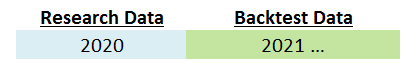

In [11]:
#@title Choose the research and test period
Research_StartDate = '2020-01-01' #@param {type:"date"}
Research_EndDate = '2020-12-31' #@param {type:"date"}

Test_StartDate = '2021-01-01' #@param {type:"date"}
Test_EndDate = '2021-12-31' #@param {type:"date"}

# Combine the stocks closes into one pandas data frame
closes = [stock['Close'] for stock in stocksDownload]
stockCloses = pd.concat(closes, axis=1)
stockCloses.columns = columnNames

# To prevent lookahead bias, split the data into research period and test period
# The Pairs identification and the trading parameters (Entry / Exit) calculations will be based on research period
# Data in test period to for backtesting
researchData = stockCloses.loc[Research_StartDate : Research_EndDate]
testData = stockCloses.loc[Test_StartDate : Test_EndDate]

# Export the data to csv file for downloading
#researchData.to_csv(RESEARCH_AJD_CLOSE_FILE, encoding='utf_8_sig')
#testData.to_csv(TEST_AJD_CLOSE_FILE, encoding='utf_8_sig')

### In case the Yahoo stock download failed, read from the prepared csv file
#researchData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/' + RESEARCH_AJD_CLOSE_FILE, index_col=0)
#testData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/' + TEST_AJD_CLOSE_FILE, index_col=0)
#columnNames = list(researchData.columns)

researchData

BABA-SW     TENCENT       CCB   MEITUAN-W  CHINA MOBILE  \
Date                                                                     
2020-01-02  208.624695  340.290161  4.293838  103.500000     43.266243   
2020-01-03  210.611603  340.824127  4.243321  104.199997     42.637276   
2020-01-06  209.618149  335.840790  4.199121  109.500000     42.537964   
2020-01-07  211.207672  343.137817  4.173863  110.400002     42.240040   
2020-01-08  209.419464  339.934235  4.142290  106.400002     42.273140   
...                ...         ...       ...         ...           ...   
2020-12-24  227.102875  497.612518  3.798498  278.200012     31.134546   
2020-12-28  208.624695  463.248230  3.878748  260.000000     31.905901   
2020-12-29  220.546097  473.512909  3.938936  273.399994     31.309860   
2020-12-30  234.653107  499.397644  3.965686  287.799988     30.748871   
2020-12-31  230.679306  505.199463  3.938936  294.000000     31.099483   

                  AIA  HSBC HOLDINGS    PING AN        HKEX      ICBC  ...  \
Date                                                                   ...   
2020-01-02  74.602463      44.973347  68.986443  223.641388  3.892275  ...   
2020-01-03  75.042877      44.604111  69.538918  228.966232  3.860107  ...   
2020-01-06  74.250168      44.308720  69.133774  230.683914  3.815073  ...   
2020-01-07  75.130951      44.234875  68.949608  231.714523  3.802206  ...   
2020-01-08  73.809784      43.791786  68.102470  230.340332  3.757171  ...   
...               ...            ...        ...         ...       ...  ...   
2020-12-24  81.763962      29.686840  69.881439  362.420319  3.092409  ...   
2020-12-28  85.217522      29.539148  70.563965  363.473389  3.242262  ...   
2020-12-29  84.499901      29.723772  70.829361  362.595886  3.337623  ...   
2020-12-30  86.383667      29.982229  71.322304  373.126221  3.358057  ...   
2020-12-31  85.621185      30.019159  72.118561  377.338379  3.412549  ...   

                HKTV     COMEC  EB SECURITIES  CHINA DONGXIANG  FLAT GLASS  \
Date                                                                         
2020-01-02  2.743021  5.552392       5.242901         0.587921    4.906547   
2020-01-03  2.711310  5.543092       5.266913         0.587921    4.897376   
2020-01-06  2.703383  5.580294       5.282923         0.574405    4.888205   
2020-01-07  2.822300  5.533791       5.282923         0.574405    5.227537   
2020-01-08  2.798516  5.840708       5.106825         0.574405    5.227537   
...              ...       ...            ...              ...         ...   
2020-12-24  8.799868  7.021870       5.166805         0.592322   28.236790   
2020-12-28  8.720589  6.798657       5.166805         0.554833   28.512720   
2020-12-29  8.704733  6.835859       5.247536         0.569829   26.903131   
2020-12-30  8.863289  6.863761       5.384779         0.614815   28.420742   
2020-12-31  9.053556  7.254383       5.610826         0.614815   30.076321   

            HEC PHARM  BROAD HOMES  FI2 CSOP HSI  FL2 CSOP HSI  LINK REIT  
Date                                                                       
2020-01-02        NaN     8.035072         6.120        10.400  56.798794  
2020-01-03        NaN     7.978421         6.170        10.320  56.419212  
2020-01-06        NaN     7.761257         6.270        10.160  56.005142  
2020-01-07        NaN     7.695163         6.240        10.180  55.901596  
2020-01-08        NaN     7.685722         6.330        10.040  55.694569  
...               ...          ...           ...           ...        ...  
2020-12-24        NaN    18.740000         5.435         8.760  49.578808  
2020-12-28        NaN    18.600000         5.460         8.715  50.370338  
2020-12-29        NaN    17.299999         5.365         8.865  51.017956  
2020-12-30        NaN    17.820000         5.140         9.260  51.665577  
2020-12-31        NaN    18.900000         5.095         9.315  50.981983  

[248 rows x 173 columns]

Dropdown(description='Stock A:', options=('BABA-SW', 'TENCENT', 'CCB', 'MEITUAN-W', 'CHINA MOBILE', 'AIA', 'HS…

Dropdown(description='Stock B:', index=1, options=('BABA-SW', 'TENCENT', 'CCB', 'MEITUAN-W', 'CHINA MOBILE', '…

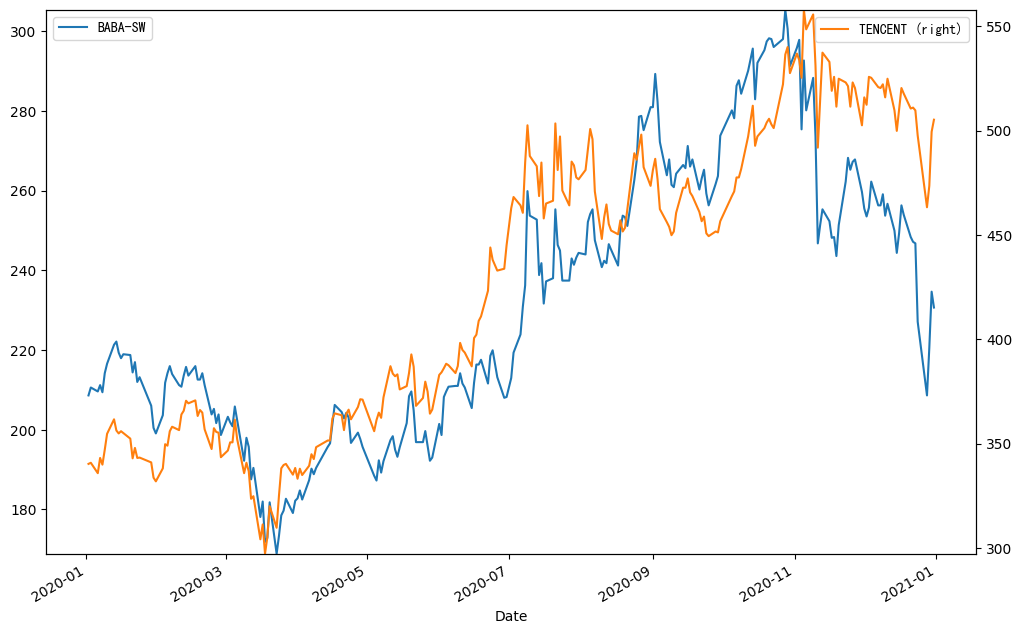

In [12]:
#@title Pick 2 stocks to display the price correlation in the research period

def dropdown_eventhandler(change):
    clear_output()
    display(stockADropdown)
    display(stockBDropdown)
    plotPair(researchData, stockADropdown.value, stockBDropdown.value, CHART_SIZE_X, CHART_SIZE_Y)

# Drop down list for the stock names
stockADropdown = widgets.Dropdown(
    description="Stock A:",
    options=columnNames
)
display(stockADropdown)
stockADropdown.observe(dropdown_eventhandler)

stockBDropdown = widgets.Dropdown(
    description="Stock B:",
    options=columnNames,
    value = columnNames[1]
)
display(stockBDropdown)
stockBDropdown.observe(dropdown_eventhandler)

plotPair(researchData, stockADropdown.value, stockBDropdown.value, CHART_SIZE_X, CHART_SIZE_Y)

#4. Pair Identifications and Selections


*   Quantify the price correlation for all stock Pair combinations
*   Using the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
*   The value is between 1 to -1 (**1**: perfectly positive correlated; **0**: No correlation; **-1**: perfectly negative correlated)

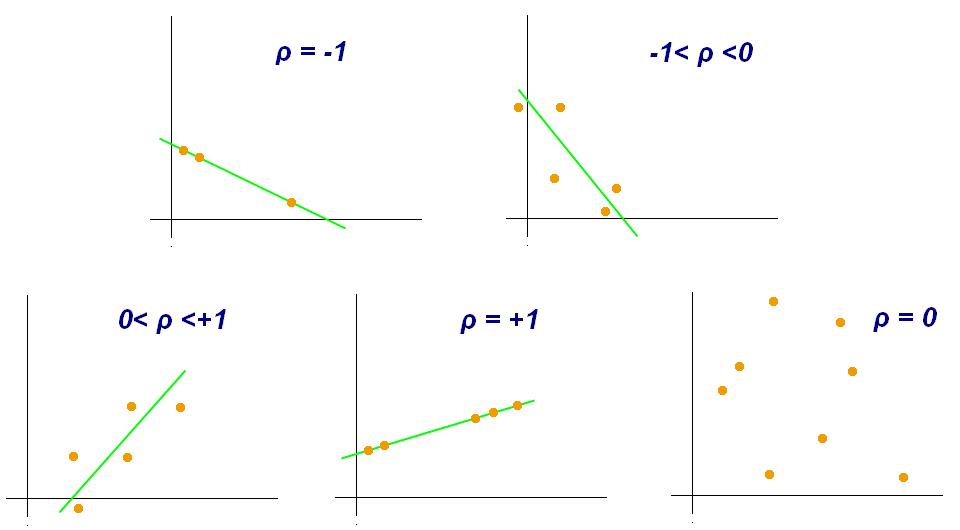

In [13]:
#@title Run the price correlation for all stock Pair combinations in research period
stocksCorr = researchData.corr()
stocksCorr.style.background_gradient(cmap='coolwarm', axis=None)

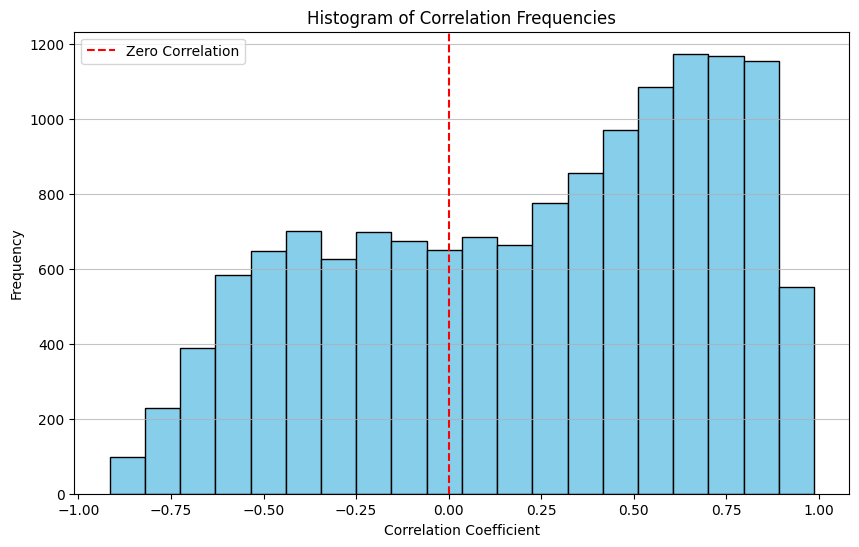

In [14]:
#@title Plot the histogram of correlation frequencies among those stock pairs

# Flatten the correlation matrix and filter out self-correlations
correlation_values = stocksCorr.values.flatten()
correlation_values = correlation_values[correlation_values != 1]  # remove self-correlation
correlation_values = np.unique(correlation_values) # remove the duplicated pair correlation

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(correlation_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Correlation Frequencies')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Correlation')
plt.legend()
plt.show()

Pairs correlation distribution is left skewed. This means that more data points are concentrated on the right (i.e. having **more positive correlated pairs than the negative ones**). It is because the **stocks tends to move togehter with the board market direction**. It is another good exercise to study the highly negative correlated pairs

In [15]:
#@title Filter the pairs with correlation values larger than the THRESHOLD

THRESHOLD = 0.95 #@param {type:"slider", min:0.5, max:1, step:0.01}
Same_Sector = True #@param {type:"boolean"}

pairsDf = getCorrelatedPairs(stocksCorr, THRESHOLD)

if Same_Sector:
  displayPairsDf = pairsDf[(pairsDf.sameSector == True)]
else:
  displayPairsDf = pairsDf

displayPairsDf.round(4)

stockA           stockB    corr                       sector_A  \
14      XINYI GLASS       FLAT GLASS  0.9655                  Glass strands   
26         WUXI BIO        PHARMARON  0.9609                  Biotechnology   
28     MEIDONG AUTO  ZHONGSHENG HLDG  0.9600                     Auto sales   
33    BANK OF CHINA             ICBC  0.9573        State-owned China banks   
34    HSBC HOLDINGS   HANG SENG BANK  0.9571                           Bank   
56      ANTA SPORTS          LI NING  0.9512                 Sporting Goods   
57  EVERSUNSHINE LS      CG SERVICES  0.9511  Property Management and Agent   
59            CNOOC       PETROCHINA  0.9506                    Oil and gas   
62      BYD COMPANY  GREATWALL MOTOR  0.9502                     Automobile   

                         sector_B  sameSector  
14                  Glass strands        True  
26                  Biotechnology        True  
28                     Auto sales        True  
33        State-owned China banks        True  
34                           Bank        True  
56                 Sporting Goods        True  
57  Property Management and Agent        True  
59                    Oil and gas        True  
62                     Automobile        True

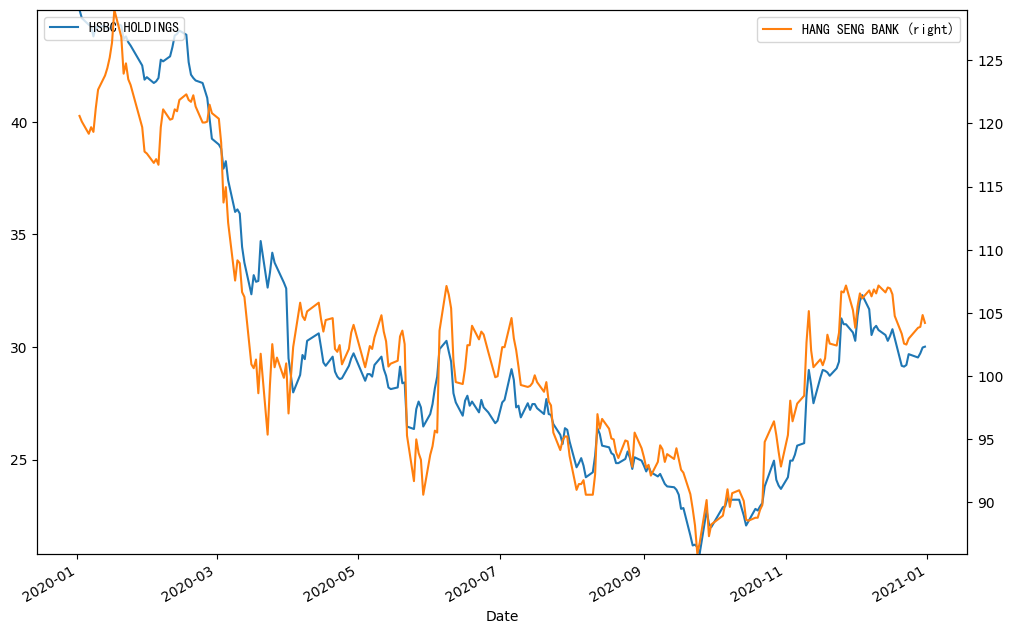

In [16]:
# Pick a stock pair price chart to to show the price correlation
selected_pair = 34

PAIR_STOCK_A = pairsDf.loc[selected_pair]['stockA']
PAIR_STOCK_B = pairsDf.loc[selected_pair]['stockB']
plotPair(researchData, PAIR_STOCK_A, PAIR_STOCK_B, CHART_SIZE_X, CHART_SIZE_Y)


#5. Determine Trading Parameters (Entry/Exit Point) in **Research Period**
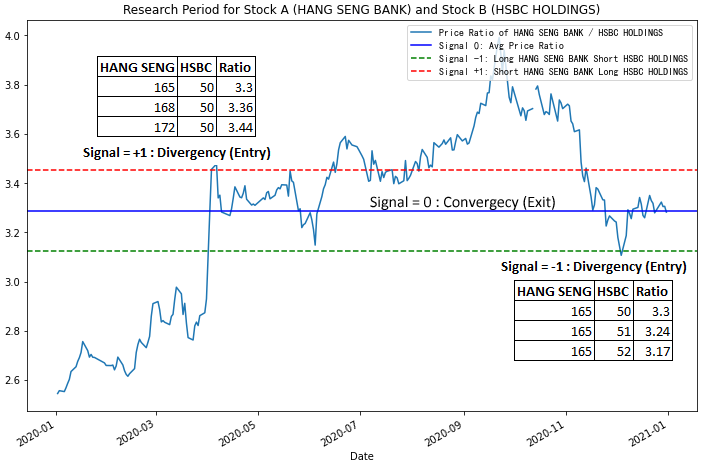

* **Price Ratio of Stock A/B**: the price relationship of stock A and B (Stock A price/ Stock B price) and it captures the **relative value**
* **Average Price Ratio of Stock A/B**: the average price ratio of the stock pair over the **research period** which represents **their long-term relationship**

* **Threshold**: define the **Divergence boundary** for trade **entry** points

* **Entry Point** (Divergence)

 * **Signal -1: Long *under-value* Stock A and Short *over-value* Stock B** when the price ratio **drops below the divergence threshold** than the average price ratio. It happens when stock A drops relatively more than stock B or stock A rises relatively less than stock B. Hence stock A is now relatively under-value to stock B

 * **Signal +1: Short *over-value* Stock A and Long *under-value* Stock B** when price ratio **rises above the divergence theshold** than the average price ratio. It happens when stock A drops relatively less than stock B or stock A rises relatively more than stock B. Hence stock A is now relatively over-value to stock B

* **Exit Point** (Convergence)

 * **Signal 0: Rewind the Position** if already created the above long/short positions, **reverse the above trade to close out the positions** when the stock pair price ratio **reverse back to the average price ratio**


In [18]:
#@title Calculate the stock price ratios of (Stock A / Stock B) which represent the relative price value over the research period

pairResearchData = researchData[[PAIR_STOCK_A, PAIR_STOCK_B]].copy()

AB_stock = PAIR_STOCK_A + " / " + PAIR_STOCK_B
pairResearchData[AB_stock] = pairResearchData[PAIR_STOCK_A] / pairResearchData[PAIR_STOCK_B]

pairResearchData[[PAIR_STOCK_A, PAIR_STOCK_B, AB_stock]]

HSBC HOLDINGS  HANG SENG BANK  HSBC HOLDINGS / HANG SENG BANK
Date                                                                     
2020-01-02      44.973347      120.597809                        0.372920
2020-01-03      44.604111      120.151733                        0.371232
2020-01-06      44.308720      119.185165                        0.371764
2020-01-07      44.234875      119.705605                        0.369531
2020-01-08      43.791786      119.333870                        0.366969
...                   ...             ...                             ...
2020-12-24      29.686840      102.968582                        0.288310
2020-12-28      29.539148      103.825356                        0.284508
2020-12-29      29.723772      103.903229                        0.286072
2020-12-30      29.982229      104.837891                        0.285987
2020-12-31      30.019159      104.214798                        0.288051

[248 rows x 3 columns]

Average BUY/SELL price ratio of HSBC HOLDINGS / HANG SENG BANK in research period: 0.29
Threadhold %: 5
Entry Point (Divergence) Signal -1 (Long A Short B): Long HSBC HOLDINGS and Short HANG SENG BANK when the BUY/SELL price ratio < 0.28
Entry Point (Divergence) Signal +1 (Short A Long B): Short HSBC HOLDINGS and Long HANG SENG BANK when the BUY/SELL price ratio > 0.31
Exit Poiont (Convergence) Signal 0: Unwind the open Long/Short positions at average price ratio: 0.29


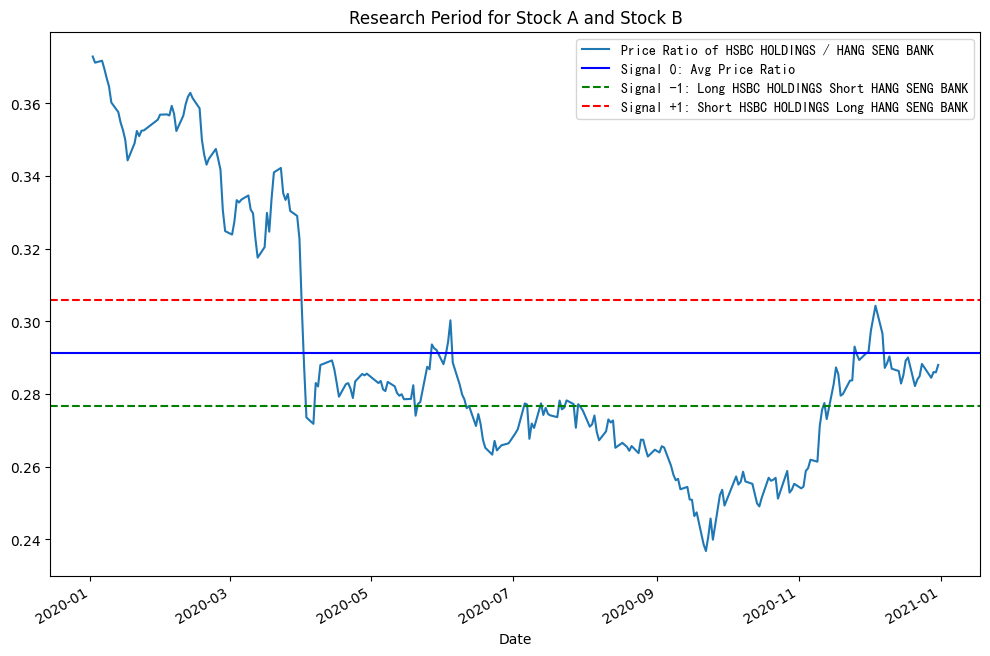

In [19]:
#@title Calculate the trading parameters based on the Threadshold % in the research period
Threshold_percent = 5 #@param {type:"slider", min:0, max:100, step:1}
PX_RATIO_THRESHOLD = Threshold_percent / 100
tradingParams = researchTradingParams(pairResearchData, PAIR_STOCK_A, PAIR_STOCK_B, PX_RATIO_THRESHOLD)

avgPxRatio = tradingParams['avgPxRatio']
longA_shortB_ratio = tradingParams['longA_shortB_ratio']
shortA_longB_ratio = tradingParams['shortA_longB_ratio']

print(f"Average BUY/SELL price ratio of {AB_stock} in research period: {avgPxRatio:.2f}")
print("Threadhold %:", Threshold_percent)

# Plot the averge price ratio in research period
#labelTitle = 'Research Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
labelTitle = 'Research Period for Stock A and Stock B'
labelPriceRatio = 'Price Ratio of {} / {}'.format(PAIR_STOCK_A, PAIR_STOCK_B)
pairResearchData[AB_stock].plot(title=labelTitle, label=labelPriceRatio, legend=True, figsize=(CHART_SIZE_X, CHART_SIZE_Y))

labelAvgPrice = 'Signal 0: Avg Price Ratio '
plt.axhline(y=avgPxRatio, label=labelAvgPrice, color='b', linestyle='-')
plt.legend(loc ='upper right')

labelLongAShortB = 'Signal -1: Long ' + PAIR_STOCK_A + ' Short ' + PAIR_STOCK_B
plt.axhline(y=longA_shortB_ratio, label=labelLongAShortB, color='g', linestyle='--')

labelShortALongB = 'Signal +1: Short ' + PAIR_STOCK_A + ' Long ' + PAIR_STOCK_B
plt.axhline(y=shortA_longB_ratio, label=labelShortALongB, color='r', linestyle='--')

plt.legend(loc ='upper right', prop=CNFont)

print(f"Entry Point (Divergence) Signal -1 (Long A Short B): Long {PAIR_STOCK_A} and Short {PAIR_STOCK_B} when the BUY/SELL price ratio < {longA_shortB_ratio:.2f}")
print(f"Entry Point (Divergence) Signal +1 (Short A Long B): Short {PAIR_STOCK_A} and Long {PAIR_STOCK_B} when the BUY/SELL price ratio > {shortA_longB_ratio:.2f}")
print(f"Exit Poiont (Convergence) Signal 0: Unwind the open Long/Short positions at average price ratio: {avgPxRatio:.2f}")

#6. Backtesting in **test period** and Calculate PnL
Backtest the strategy in the **test period** with the **trading parameters from research period**


* **Mark the signals (+1, -1, 0)** according to the Pair price ratio and the convergence / divengence threshold
* When (signal = +/-1), **enter the trade** by using the specified dollarValue to create positions (e.g. create \$10,000 long on Stock A and \$10,000 short positions on Stock B at the same time). Assume the execution is perfect and can long/short at equal dollar amount
* When (signal = 0), **exit the trade** by unwinding the open long/short positions (i.e. sell the long position and cover the short)
* **StopLoss** when the Pair price ratio is too much further away from the divergence. It could mean the underlying relationship of this Pair is brokern and needs to exit the trade with loss


Calculate the PnL


*   **Trading PnL**: when enter and exit the positions, calculate the profit or loss from the stocks execution price
*   **Trading cost**: based on the annual **short interest rate** and the **transaction cost** of buying and selling the stocks


Entry Point (Divergence) Signal == -1 (Long A Short B): Long HSBC HOLDINGS and Short HANG SENG BANK when the BUY/SELL price ratio < 0.28
Entry Point (Divergence) Signal == +1 (Short A Long B): Short HSBC HOLDINGS and Long HANG SENG BANK when the BUY/SELL price ratio > 0.31
Exit Poiont (Convergence) Signal == 0 : Within the above range or Unwind the open Long/Short positions at average price ratio: 0.29
------------------------------------------------------------------------------------------------------------
Trading P&L: 954.17, ShortSell Interest:119.53, Transaction Cost:700.60
*** Net P&L: 134.05


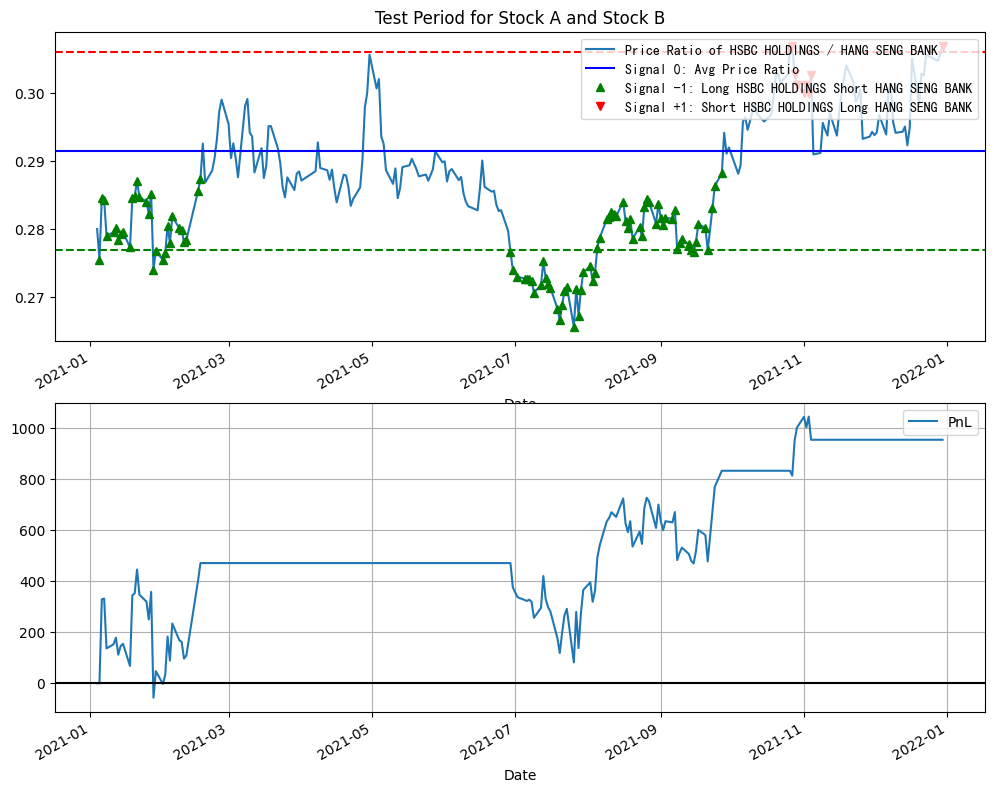

In [20]:
#@title Run back testing with different parameters

dollarValue = 10000 #@param {type:"number"}
stopLossPercent = 10 #@param {type:"slider", min:0, max:50, step:1}
shortInterestPercent = 3 #@param {type:"slider", min:0, max:20, step:0.01}
transactionPercent = 0.5 #@param {type:"slider", min:0, max:20, step:0.01}

print(f"Entry Point (Divergence) Signal == -1 (Long A Short B): Long {PAIR_STOCK_A} and Short {PAIR_STOCK_B} when the BUY/SELL price ratio < {tradingParams['longA_shortB_ratio']:.2f}")
print(f"Entry Point (Divergence) Signal == +1 (Short A Long B): Short {PAIR_STOCK_A} and Long {PAIR_STOCK_B} when the BUY/SELL price ratio > {tradingParams['shortA_longB_ratio']:.2f}")
print(f"Exit Poiont (Convergence) Signal == 0 : Within the above range or Unwind the open Long/Short positions at average price ratio: {tradingParams['avgPxRatio']:.2f}")
print("------------------------------------------------------------------------------------------------------------")

# Backtest a Pair in test period
stopLoss = stopLossPercent / 100
backTest_df = backTest(testData, tradingParams, PAIR_STOCK_A, PAIR_STOCK_B, dollarValue, stopLoss)

# Calcuate the PnL in test period
shortInterest = shortInterestPercent / 100
transaction = transactionPercent / 100

pnl, pnl_df = calcPnl(backTest_df, shortInterest, transaction)
print(f"Trading P&L: {pnl['tradingPnL']:.2f}, ShortSell Interest:{pnl['shortInterest']:.2f}, Transaction Cost:{pnl['transCost']:.2f}")
print(f"*** Net P&L: {(pnl['tradingPnL'] - pnl['shortInterest'] - pnl['transCost']):.2f}")
print("=============================================")
#cols = [PAIR_STOCK_A, PAIR_STOCK_B, 'pxRatio', 'signal', 'longValue', 'shortValue', 'longPos', 'shortPos', 'longPnl', 'shortPnl', 'pnl', 'totalPnl']
#pnl_df[cols].round(4)


# Plot the backtest and PnL results
pnl_df = addSignalMarker(pnl_df)
fig, axes = plt.subplots(2, 1)

#labelTitle = 'Test Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
labelTitle = 'Test Period for Stock A and Stock B'
pnl_df.pxRatio.plot(ax=axes[0], title=labelTitle, label=labelPriceRatio, legend=True)
axes[0].axhline(y=avgPxRatio, label=labelAvgPrice, color='b', linestyle='-')
pnl_df.nSignal.plot(ax=axes[0], label=labelLongAShortB, color='g', linestyle='None', marker='^', legend=True)
pnl_df.pSignal.plot(ax=axes[0], label=labelShortALongB, color='r', linestyle='None', marker='v', legend=True)

axes[0].axhline(y=longA_shortB_ratio, color='g', linestyle='--')
axes[0].axhline(y=shortA_longB_ratio, color='r', linestyle='--')
axes[0].legend(loc ='upper right', prop=CNFont)

pnl_df.totalPnl.plot(ax=axes[1], label='PnL', legend=True, figsize=(CHART_SIZE_X, 10), grid=True)
axes[1].axhline(y=0, color='black', linestyle='-')


In [21]:
#@title Run the entire Pair portfolio PnL

Same_Sector = True #@param {type:"boolean"}

# Selects the Pairs with same sectors into the portfolio
selectedPairsDf = pairsDf[(pairsDf.sameSector == Same_Sector)]
print("Total pairs for backtesting:", len(selectedPairsDf))
print('----------------------------------------------------------')

# Research the trading params and back test the selected Pairs in test period
pairsPortfolioBackTest = researchAndBackTestPortfolio(selectedPairsDf, researchData, testData, PX_RATIO_THRESHOLD, dollarValue, stopLoss, printOutput=False)

# Calcuate the PnL of the Pairs portfolio
pnl, pnlDf = calcPortfolio(pairsPortfolioBackTest,shortInterest, transaction)
pnlDf

Total pairs for backtesting: 9
----------------------------------------------------------
XINYI GLASS vs FLAT GLASS ---> $0.00
WUXI BIO vs PHARMARON ---> $-489.45
MEIDONG AUTO vs ZHONGSHENG HLDG ---> $0.00
BANK OF CHINA vs ICBC ---> $-828.06
HSBC HOLDINGS vs HANG SENG BANK ---> $134.05
ANTA SPORTS vs LI NING ---> $-639.64
EVERSUNSHINE LS vs CG SERVICES ---> $-331.78
CNOOC vs PETROCHINA ---> $24.59
BYD COMPANY vs GREATWALL MOTOR ---> $0.00
PortfolioPnl: $-2130.30


stockA          stocksB  tradingPnL  shortInterest    transCost  \
0      XINYI GLASS       FLAT GLASS    0.000000       0.000000     0.000000   
1         WUXI BIO        PHARMARON  852.151237     114.843750  1226.761519   
2     MEIDONG AUTO  ZHONGSHENG HLDG    0.000000       0.000000     0.000000   
3    BANK OF CHINA             ICBC -189.232831     233.203125   405.619652   
4    HSBC HOLDINGS   HANG SENG BANK  954.173341     119.531250   700.595051   
5      ANTA SPORTS          LI NING  245.371488      60.937500   824.076176   
6  EVERSUNSHINE LS      CG SERVICES -112.355828       3.515625   215.908802   
7            CNOOC       PETROCHINA  740.709586      93.750000   622.373466   
8      BYD COMPANY  GREATWALL MOTOR    0.000000       0.000000     0.000000   

          Pnl  
0    0.000000  
1 -489.454032  
2    0.000000  
3 -828.055608  
4  134.047040  
5 -639.642188  
6 -331.780255  
7   24.586120  
8    0.000000

# Notes
---
### **Pair Identifications and Selections**

Ideal properties of the pairs:

1. The pairs constituents are cointegrated.
2. The pairs reveals a mean-reverting character.
3. The pairs diverges and converges within convenient periods.
4. The pairs reverts to the mean with enough frequency.

This code uses the adjusted closing price and pandas default corr function (Pearson correlation coefficient) to determine the pairs correlations. However, it is generally more desirable to use **co-integration rather than correlation**.



* http://epchan.blogspot.com/2006/11/cointegration-is-not-same-as.html
* https://blog.quantinsti.com/pairs-trading-basics/
* https://kidquant.com/project/pairs-trading-strategies-in-python/


Pairs with stocks in the same sector share the same macro fundamental factors and prevent spurious correlation. However, it may be too restrictive and excludes some pairs opportunities. For example, "Photovoltaic Solar" and "Glass strands" may be correlated (upstream/downstream in the industry) but they're in different sectors

Use **clustering alogrithms** (such as k-mean or DBScan) to group similar stocks together and trade Pairs with the stocks from the same cluster

* https://blog.quantinsti.com/k-means-clustering-pair-selection-python/
* https://algotrading101.com/learn/cluster-analysis-guide/


---

### **Trading Parameters**
* **Ratio or Spread:** Stocks relationship can be expressed as **price spread** (Stock Price A - Stock Price B) rathan than price ratio (Stock Price A / Stock Price B).

* **Divergence Threshold:** Instead of using an arithmetic average price over the entire research period with a fixed percentage threshold, the divergence threshold is determined by a **z-score**. This z-score measures the number of **standard deviations** the current ratio/spread deviates from its **historical moving average**, calculated over a specific lookback period.

* **Improve strategy entry /exit points:** there's no guarantee that the point immediately after crossing the threshold is an optimal entry point. The spread might continue to diverge before converging again. Use **technincal indicators** (e.g. bollinger bands) or **Machine Learning** (e.g. decision tree, LSTM) to predict the price movements to improve the entry/exit.

* **Dynamic Stop Loss:** Prevent the stocks pair from diverging too much (may be the underlying relationship is broken due to some external events).

* **Position sizing:** dollar value for each pair trade can be different but need a way to determine the optimal amount.
